## Introduction
---
- Machine Learning applications in the field of Medicine to support and help the diagnosis of various diseases is crucial, to catch these at an early state. For this the algorithms
used have to take into account the most telling characteristics about the tests performed to analyze the targeted anatomical part of the patient. This is true in the particular case of Brain Tumors where there are typical exams that are prescribged in order to find if there is a tumor in the cerebral cortex of the patient.
- With the intent to build a model that classifies the imagiological results of tests like CT scans and MRIs into 'healty' or 'cancer' classes, to support the specialists decisions, we decided to train said model with a dataset with about 4600 unique samples of these types of exams, consisting their image results. 
-Given time we will explore the classification between different types of cancer in the brain cancer category.
---
## Step 1 - Data Exploration and Preprocessing

- Inspecting the dataset structure and labels:  
  - here is where we can separate the dataset through the labels Cancer/Healthy;
  - given the separation we may start to operate in the dataset

- The 1st operation needed is to reduce the images to a fixed shape, normalizing them into the same resolution;
- Next we also need to split the dataset as said in the project proposal, in "Training Data" and "Testing Data";
---
#### Process
- For this step then we will use "pandas" library to read the CSV metadata in order to get the information provided about the images
- When this is completed we will separate the data into "Healthy" and "Cancer" lists
- After this the main preprocessing of the data will begin 

In [6]:
import numpy as np
import pandas as pd

DEBUG = True

csv_file = "./data/metadata_rgb_only.csv"

"""This method reads the data from a CSV file
returning said data."""
def read_data(csv_file):
    df = pd.read_csv(csv_file)
    return df 

data = read_data(csv_file)

if DEBUG == True:
    print(f"🔴--------------🔴   Debug   🔴--------------🔴\n")
    print(data)
    

🔴--------------🔴   Debug   🔴--------------🔴

      Unnamed: 0                  image   class format mode          shape
0              0         Cancer (1).jpg   tumor   JPEG  RGB  (512, 512, 3)
1              2         Cancer (1).tif   tumor   TIFF  RGB  (256, 256, 3)
2              3        Cancer (10).jpg   tumor   JPEG  RGB  (512, 512, 3)
3              4        Cancer (10).tif   tumor   TIFF  RGB  (256, 256, 3)
4              5       Cancer (100).jpg   tumor   JPEG  RGB  (512, 512, 3)
...          ...                    ...     ...    ...  ...            ...
4456        4595  Not Cancer  (995).jpg  normal   JPEG  RGB  (168, 300, 3)
4457        4596  Not Cancer  (996).jpg  normal   JPEG  RGB  (509, 452, 3)
4458        4597  Not Cancer  (997).jpg  normal   JPEG  RGB  (197, 177, 3)
4459        4598  Not Cancer  (998).jpg  normal   JPEG  RGB  (217, 232, 3)
4460        4599  Not Cancer  (999).jpg  normal   JPEG  RGB  (221, 228, 3)

[4461 rows x 6 columns]


#### Part 1 - Completed
---
- For now we have a variable `data` that has all the information in the file metadata stored in an N column matrix. Since this is the case we can pick and choose the data that we need to separate in the different classes. 

In [7]:
def get_list(data, column):
    list = data[column] # get the info on column class
    return list 

# Get the image labels
labels = get_list(data, column="class")

if DEBUG == True:
    print(f"\n🔴--------------🔴   Debug   🔴--------------🔴\n")
    print(labels, sep="\n")

# Get the images list
images = get_list(data, column="image")

if DEBUG == True:
    print(f"\n🔴--------------🔴   Debug   🔴--------------🔴\n")
    print(images)

# Split the images into healty/cancer
cancer = images[labels=="tumor"]
healthy = images[labels=="normal"]

print(cancer, healthy, sep="\n\n")


🔴--------------🔴   Debug   🔴--------------🔴

0        tumor
1        tumor
2        tumor
3        tumor
4        tumor
         ...  
4456    normal
4457    normal
4458    normal
4459    normal
4460    normal
Name: class, Length: 4461, dtype: object

🔴--------------🔴   Debug   🔴--------------🔴

0              Cancer (1).jpg
1              Cancer (1).tif
2             Cancer (10).jpg
3             Cancer (10).tif
4            Cancer (100).jpg
                ...          
4456    Not Cancer  (995).jpg
4457    Not Cancer  (996).jpg
4458    Not Cancer  (997).jpg
4459    Not Cancer  (998).jpg
4460    Not Cancer  (999).jpg
Name: image, Length: 4461, dtype: object
0         Cancer (1).jpg
1         Cancer (1).tif
2        Cancer (10).jpg
3        Cancer (10).tif
4       Cancer (100).jpg
              ...       
2416    Cancer (994).JPG
2417    Cancer (995).jpg
2418    Cancer (996).jpg
2419    Cancer (998).JPG
2420    Cancer (999).jpg
Name: image, Length: 2421, dtype: object

2421       Not

#### Part 2 - Completed
---
- Separation of the images into the binary classes predetermined: `cancer` & `healthy` 
- With this we have the possibility of determining the priors for example
- We should also split the dataset in `training` and `testing data` @ this point


🔴--------------🔴   Debug   🔴--------------🔴



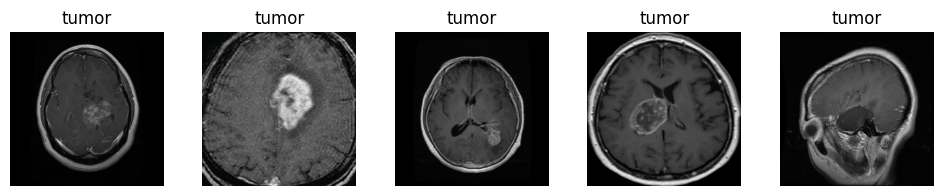

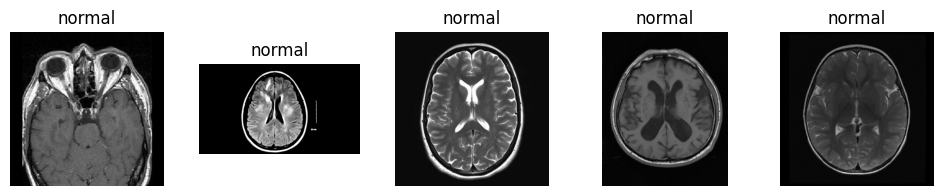

Number of cancer images: 2421
Number of healthy images: 2040


In [8]:
import matplotlib.pyplot as plt
from PIL import Image
import random as rand
import os

cancer_img_dir= "./data/cancer"
healthy_img_dir = "./data/healthy"

N = 5

def random_plot(image_list, label, image_dir, n=N):
    plt.figure(figsize=(12,2))
    for i, img_name in enumerate(image_list[:n]):
        img_path = os.path.join(image_dir, img_name)
        img = Image.open(img_path)
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(label)
    plt.show()

if DEBUG == True:
    print(f"\n🔴--------------🔴   Debug   🔴--------------🔴\n")
    random_plot(cancer.to_list(), "tumor", cancer_img_dir)
    random_plot(healthy.to_list(), "normal", healthy_img_dir)
    print(f"Number of cancer images: {len(cancer)}")
    print(f"Number of healthy images: {len(healthy)}")

#### Part 3 - Split the data into Training/Testing
---
- This will be split in an 80/20 where both classes hgave to be reasonably represented in the samples, especially in the training data
- First we will use the train_test_split method to split the data, after the data has been combined as a single list with labels and images 
- Note: 
  - in the train_test_split function the value 42 choosen for `random_state` is choosen as it is a standard value, choosen to ensure reproduceability, meaning that it ensures that the data split is always the same every time the code is run, however it is just a random value and any can be used as long as it is maintained the same throughout multiple runs of the code.   

In [9]:
from sklearn.model_selection import train_test_split

# Splitting the data in testing and training data samples
all_images = cancer.to_list() + healthy.to_list()
all_labels = ['tumor'] * len(cancer) + ['normal'] * len(healthy)

X_training, X_test, y_training, y_test = train_test_split(
    all_images, all_labels, test_size=0.2, stratify=all_labels, random_state=42
)

if DEBUG == True:
    print(f"\n🔴--------------🔴   Debug   🔴--------------🔴\n")
    print(f"Training DataSet size = {len(X_training)}, TestSize = {len(X_test)}" )
    print(y_training, sep="\n")
    print(y_test, sep="\n")


🔴--------------🔴   Debug   🔴--------------🔴

Training DataSet size = 3568, TestSize = 893
['tumor', 'normal', 'tumor', 'tumor', 'tumor', 'tumor', 'normal', 'tumor', 'normal', 'tumor', 'normal', 'normal', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'normal', 'normal', 'normal', 'tumor', 'tumor', 'tumor', 'normal', 'normal', 'tumor', 'tumor', 'normal', 'tumor', 'tumor', 'tumor', 'normal', 'normal', 'normal', 'tumor', 'normal', 'normal', 'normal', 'tumor', 'normal', 'normal', 'normal', 'normal', 'normal', 'tumor', 'normal', 'tumor', 'tumor', 'normal', 'tumor', 'normal', 'normal', 'normal', 'tumor', 'normal', 'normal', 'normal', 'tumor', 'normal', 'tumor', 'tumor', 'normal', 'normal', 'normal', 'tumor', 'normal', 'normal', 'normal', 'tumor', 'normal', 'normal', 'normal', 'tumor', 'tumor', 'normal', 'normal', 'tumor', 'normal', 'tumor', 'tumor', 'tumor', 'tumor', 'normal', 'normal', 'normal', 'normal', 'tumor', 'tumor', 'normal', 'normal', 'tumor', 'tumor', 'tumor', 'normal', 'tumor', 'no

#### Part 4 - Image Preprocessing/Normalization
---
- Since the images have different resolutions they shoulf be normalized to the same size in order to build a solid foundation of comparison to train the model.

In [10]:
def preprocess_img(img_path, target_size =(256, 256)):
    
    img = Image.open(img_path).convert('RGB')
    img = img.resize(target_size)
    img_array = np.array(img) / 255.0
    
    return img_array

